In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('./datasets/Sentiment.csv')
df.head()

,id,sentiment,text
0,1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
1,2,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
2,3,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
3,4,Positive,"RT @GregAbbott_TX: @TedCruz: ""On my first day ..."
4,5,Negative,RT @warriorwoman91: I liked her and was happy ...


In [6]:
# Preprocessing
import numpy as np

In [7]:
df['sentiment']=np.where(df.sentiment=='Positive',1,0)

In [8]:
# clean text
import re

In [9]:
text = df['text'][3]
print(text)

handle_regex = r'@([\S])+(:)*'
new_text = re.sub(handle_regex, '', text)
print(new_text)

RT @GregAbbott_TX: @TedCruz: "On my first day I will rescind every illegal executive action taken by Barack Obama." #GOPDebate @FoxNews
RT   "On my first day I will rescind every illegal executive action taken by Barack Obama." #GOPDebate 


In [10]:
# remove stop words as well
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielmatheison/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stCol1 = stopwords.words('english')

In [12]:
def cleanText(text):
    # remove handles
    text=re.sub(handle_regex,"",text)
    # remove special char and numbers
    text=re.sub('[^A-Za-z\s]',"",text)
    #remove stopwords and 2 or less char words
    text=' '.join([word.lower() for word in text.split() if word.lower() not in stCol1 and len(word)>2])
    return(text)

In [13]:
df['cleaned_text'] = df['text'].apply(cleanText)
df.head()

,id,sentiment,text,cleaned_text
0,1,1,RT @ScottWalker: Didn't catch the full #GOPdeb...,didnt catch full gopdebate last night scotts b...
1,2,1,RT @RobGeorge: That Carly Fiorina is trending ...,carly fiorina trending hours debate men justco...
2,3,1,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,gopdebate delivered highest ratings history pr...
3,4,1,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",first day rescind every illegal executive acti...
4,5,0,RT @warriorwoman91: I liked her and was happy ...,liked happy heard going moderator anymore gopd...


In [14]:
# tokenize data
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
NUM_WORDS=2000
tk = Tokenizer(num_words=NUM_WORDS)

In [16]:
tk.fit_on_texts(df['cleaned_text'])
x = tk.texts_to_sequences(df['cleaned_text'])
x[0:3]

[[47, 548, 1, 10, 16, 86, 1463, 1153, 64],
 [142, 152, 640, 7, 85, 1, 134, 549],
 [1, 1617, 1349, 122, 531, 97, 115, 3, 501]]

In [17]:
# pad sequences
from tensorflow.keras.utils import pad_sequences

In [18]:
MAX_WORD_LEN=60
x_pd = pad_sequences(x,maxlen=MAX_WORD_LEN)
print(x_pd)

[[   0    0    0 ... 1463 1153   64]
 [   0    0    0 ...    1  134  549]
 [   0    0    0 ...  115    3  501]
 ...
 [   0    0    0 ...   37   18    2]
 [   0    0    0 ...  378  819 1160]
 [   0    0    0 ...  107    2  547]]


In [19]:
# train test split 
y = df['sentiment']
from sklearn.model_selection import train_test_split

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x_pd,y,random_state=0,stratify=y)

# Attention

In [28]:
# build model
from keras_self_attention import SeqSelfAttention

from tensorflow.keras.layers import Embedding, Dense, Flatten, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from livelossplot import PlotLossesKerasTF

In [30]:
model=Sequential()
model.add(Embedding(input_dim=NUM_WORDS,output_dim=128,input_length=x_train.shape[1]))
model.add(GRU(32,return_sequences=True))  # Add attention mechanism
model.add(SeqSelfAttention(attention_activation='softmax'))  # Add attention layer
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 128)           256000    
                                                                 
 gru_1 (GRU)                 (None, 60, 32)            15552     
                                                                 
 seq_self_attention_2 (SeqSe  (None, 60, 32)           2113      
 lfAttention)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1921      
                                                                 
Total params: 275,586
Trainable params: 275,586
Non-trainable params: 0
________________________________________________

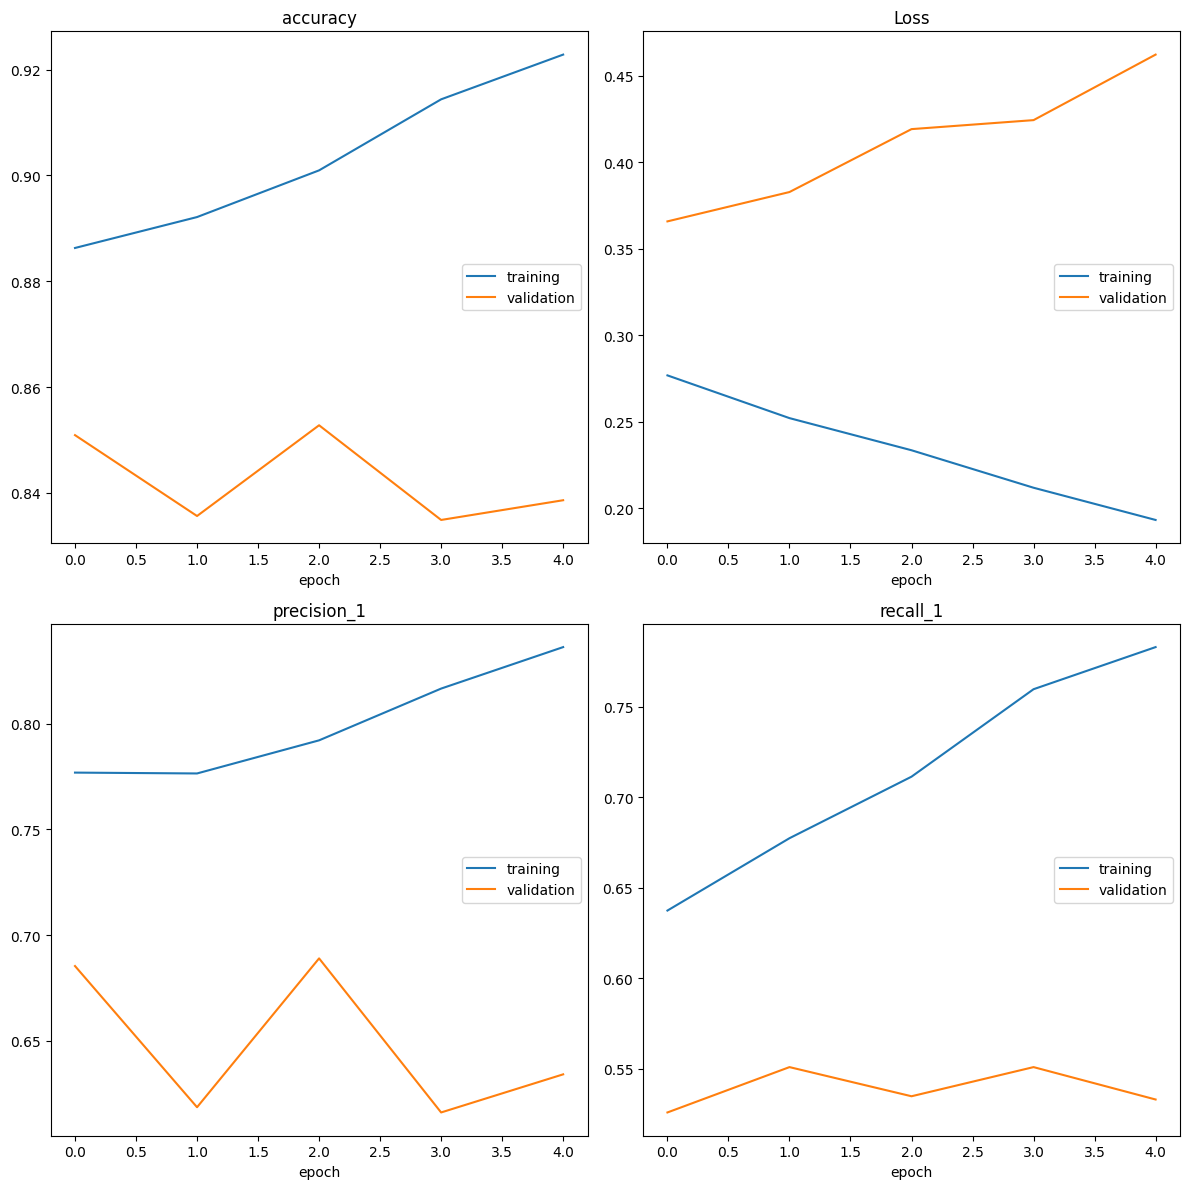

accuracy
	training         	 (min:    0.886, max:    0.923, cur:    0.923)
	validation       	 (min:    0.835, max:    0.853, cur:    0.839)
Loss
	training         	 (min:    0.193, max:    0.277, cur:    0.193)
	validation       	 (min:    0.366, max:    0.462, cur:    0.462)
precision_1
	training         	 (min:    0.776, max:    0.836, cur:    0.836)
	validation       	 (min:    0.616, max:    0.689, cur:    0.634)
recall_1
	training         	 (min:    0.637, max:    0.783, cur:    0.783)
	validation       	 (min:    0.526, max:    0.551, cur:    0.533)
252/252 [==============================] - 24s 96ms/step - loss: 0.1931 - accuracy: 0.9228 - precision_1: 0.8363 - recall_1: 0.7829 - val_loss: 0.4622 - val_accuracy: 0.8386 - val_precision_1: 0.6340 - val_recall_1: 0.5331
Epoch 6/10
201/252 [======================>.......] - ETA: 4s - loss: 0.1724 - accuracy: 0.9310 - precision_1: 0.8585 - recall_1: 0.8053

KeyboardInterrupt: 

In [33]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', Precision(), Recall()]
)

model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test,y_test),
    callbacks=[PlotLossesKerasTF()]
)